- 타임라인 이력 파일은 두 번째 및 후속 PITR 프로세스에서 중요한 역할을 함.
  - 두 번째 복구를 시도하여 어떻게 사용되는지 살펴봄.

- 이번에도 timelineId가 2인 복구된 데이터베이스 클러스터에서 '12:15:00'에 실수를 했다고 가정.
  -  이 경우 데이터베이스 클러스터를 복구하려면 아래와 같이 새로운 Recovery.conf 파일을 생성해야 함.



```

restore_command = 'cp /mnt/server/archivedir/%f %p'
recovery_target_time = "2024-1-1 12:15:00 GMT"
recovery_target_timeline = 2
```

- 'recovery_target_time' 매개변수는 새로운 실수를 저지른 시간을 설정하고, 'recovery_target_timeline' 매개변수는 해당 타임라인에 따라 복구하기 위해 2로 설정됨.

- PostgreSQL 서버를 다시 시작하고 PITR 모드로 들어가 TimelineId 2를 따라 대상 시간에 데이터베이스를 복구

**Recover the database at 12:15:00 along the timelineId 2.**

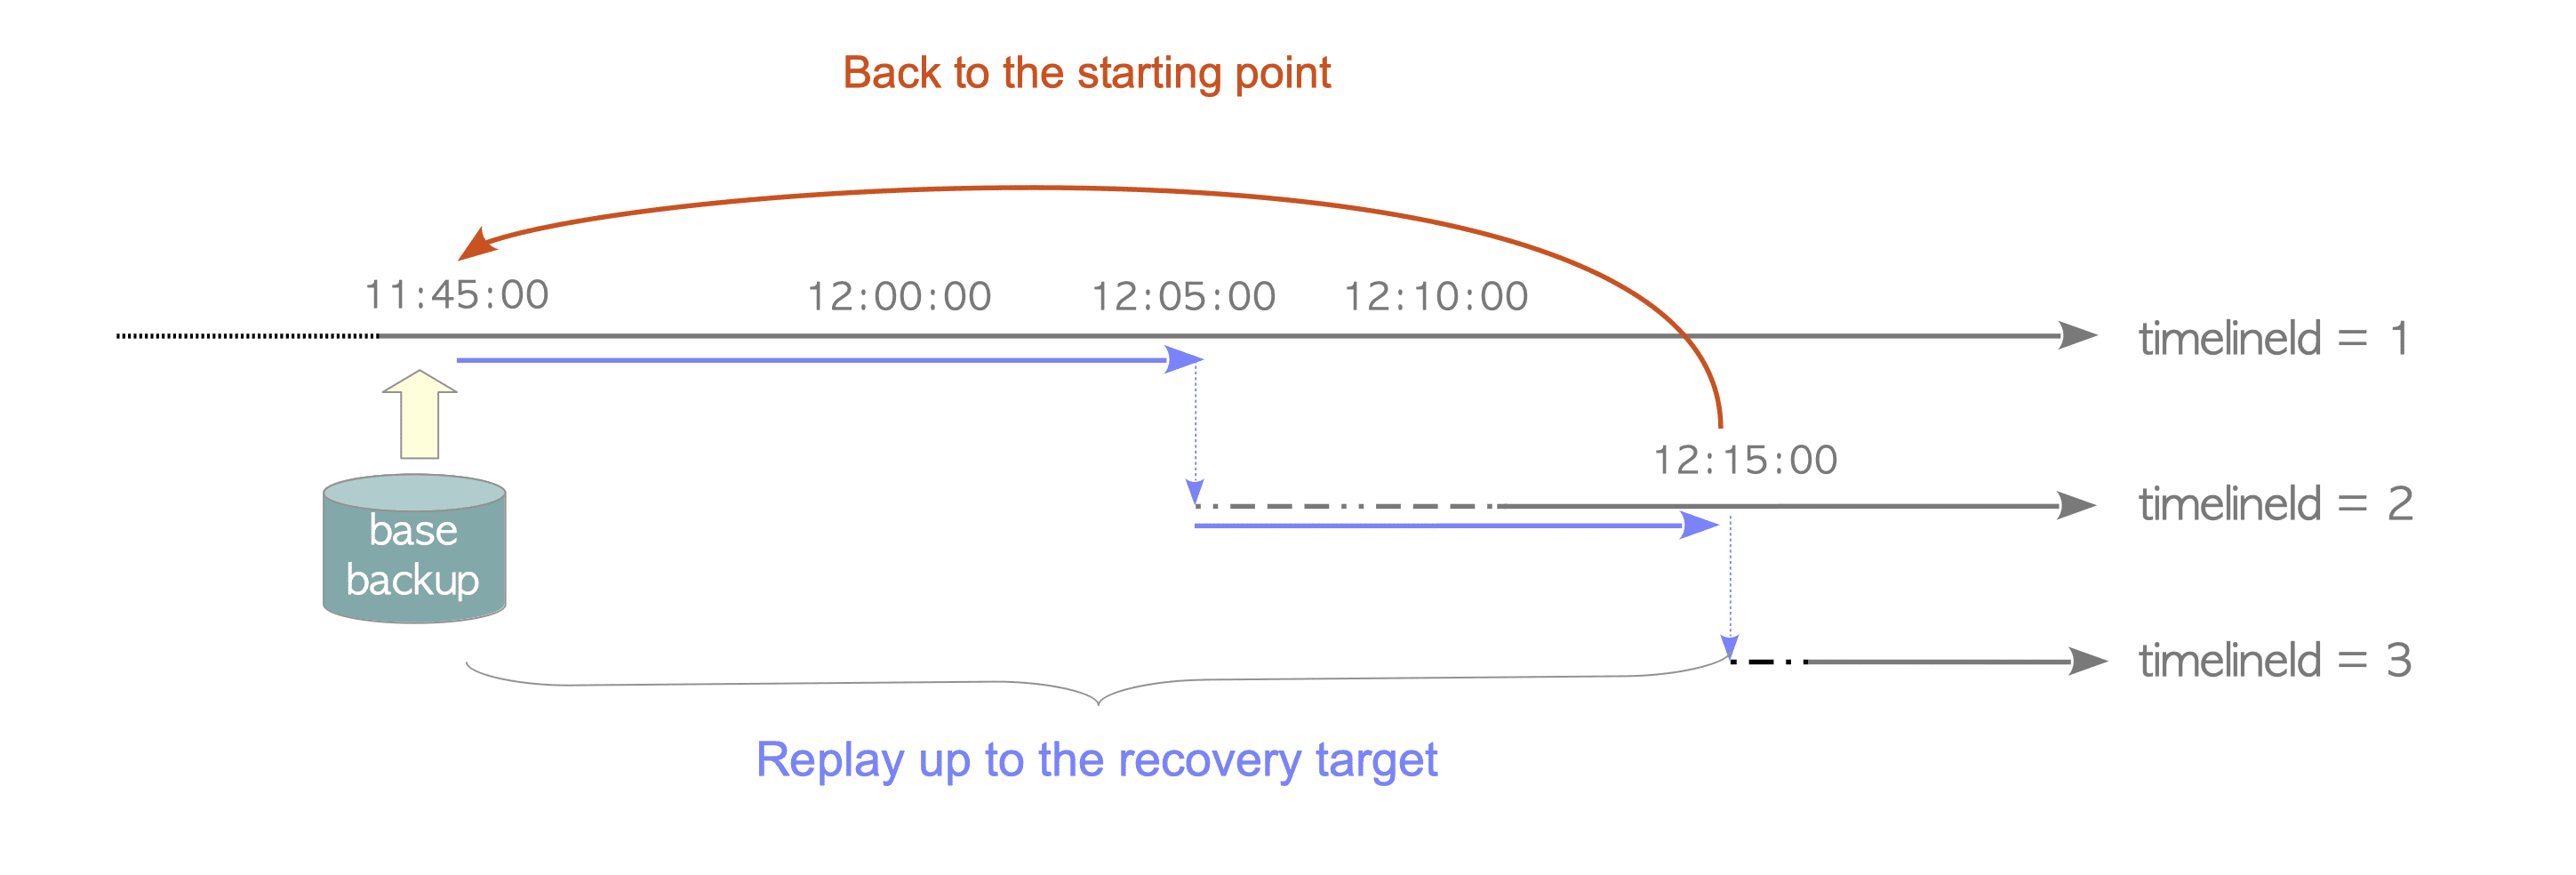

1. PostgreSQL은 backup_label 파일에서 'CHECKPOINT LOCATION' 값을 읽음.

2. 일부 매개변수 값은 Recovery.conf에서 읽혀짐.
  -  이 예에서는 'restore_command', 'recovery_target_time' 및 'recovery_target_timeline'.

3. PostgreSQL은 'recovery_target_timeline' 파라미터 값에 해당하는 타임라인 히스토리 파일 '00000002.history'를 읽어옴.

4. PostgreSQL은 다음 단계에 따라 WAL 데이터를 재생.

  - REDO 지점부터 '00000002.history' 파일에 기록된 LSN '0/A000198'까지 PostgreSQL은 timelineId가 1인 해당 아카이브 로그의 WAL 데이터를 읽고 재생.
  - LSN '0/A000198' 이후부터 타임스탬프 '2024-1-1 12:15:00' 이전까지 PostgreSQL은 timelineId가 2인 WAL 데이터(해당 아카이브 로그의)를 읽고 재생.

5. 복구 프로세스가 완료되면 현재 timelineId가 3으로 올라가고 pg_wal 하위 디렉터리(9.6 이하 버전의 경우 pg_xlog)와 archive 디렉터리에 '00000003.history'라는 이름의 새로운 타임라인 히스토리 파일이 생성됨.



```
postgres> cat /home/postgres/archivelogs/00000003.history
1         0/A000198     before 2024-1-1 12:05:00.861324+00

2         0/B000078     before 2024-1-1 12:15:00.927133+00
```

- PITR을 두 번 이상 수행하는 경우 적절한 타임라인 기록 파일을 사용하기 위해 timelineId를 명시적으로 설정해야 함.

- 이와 같이 타임라인 이력 파일은 데이터베이스 클러스터의 이력 로그일 뿐만 아니라 PITR 프로세스에 대한 복구 지침 문서이기도 함.

